# Distributed KernelSHAP

## Introduction

In this example, KernelSHAP is used to explain a batch of instances on multiple cores. To run this example, please run ``pip install alibi[ray]`` first.

In [1]:
import pprint
import shap
import ray
shap.initjs()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from alibi.explainers import KernelShap
from alibi.datasets import fetch_adult
from collections import defaultdict
from scipy.special import logit
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from timeit import default_timer as timer
from typing import Dict, List, Tuple

## Data preparation

### Load and split

The `fetch_adult` function returns a `Bunch` object containing the features, the targets, the feature names and a mapping of categorical variables to numbers.

In [2]:
adult = fetch_adult()
adult.keys()

dict_keys(['data', 'target', 'feature_names', 'target_names', 'category_map'])

In [3]:
data = adult.data
target = adult.target
target_names = adult.target_names
feature_names = adult.feature_names
category_map = adult.category_map

Note that for your own datasets you can use our utility function `gen_category_map` to create the category map.

In [4]:
from alibi.utils.data import gen_category_map

In [5]:
np.random.seed(0)
data_perm = np.random.permutation(np.c_[data, target])
data = data_perm[:,:-1]
target = data_perm[:,-1]

In [6]:
idx = 30000
X_train,y_train = data[:idx,:], target[:idx]
X_test, y_test = data[idx+1:,:], target[idx+1:]

### Create feature transformation pipeline
Create feature pre-processor. Needs to have 'fit' and 'transform' methods. Different types of pre-processing can be applied to all or part of the features. In the example below we will standardize ordinal features and apply one-hot-encoding to categorical features.

Ordinal features:

In [7]:
ordinal_features = [x for x in range(len(feature_names)) if x not in list(category_map.keys())]
ordinal_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler())])

Categorical features:

In [8]:
categorical_features = list(category_map.keys())
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                          ('onehot', OneHotEncoder(drop='first', handle_unknown='error'))])

Note that in order to be able to interpret the coefficients corresponding to the categorical features, the option `drop='first'` has been passed to the `OneHotEncoder`. This means that for a categorical variable with `n` levels, the length of the code will be `n-1`. This is necessary in order to avoid introducing feature multicolinearity, which would skew the interpretation of the results. For more information about the issue about multicolinearity in the context of linear modelling see [[1]](#References).
<a id='src_1'></a>

Combine and fit:

In [9]:
preprocessor = ColumnTransformer(transformers=[('num', ordinal_transformer, ordinal_features),
                                               ('cat', categorical_transformer, categorical_features)])
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 [0, 8, 9, 10]),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'))]),
                                 [1, 2, 3, 4, 5, 6, 7, 11])])

### Preprocess the data

In [10]:
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)

Applying the `sklearn` processing pipeline modifies the column order of the original dataset. The new feature ordering is necessary in order to corectly plot visualisations, and is inferred from the `preprocessor` object below:

In [11]:
numerical_feats_idx  = preprocessor.transformers_[0][2]
categorical_feats_idx  = preprocessor.transformers_[1][2]
scaler = preprocessor.transformers_[0][1].named_steps['scaler']
num_feats_names = [feature_names[i] for i in numerical_feats_idx]
cat_feats_names = [feature_names[i] for i in categorical_feats_idx]
perm_feat_names = num_feats_names + cat_feats_names 

In [12]:
pp = pprint.PrettyPrinter()
print("Original order:")
pp.pprint(feature_names)
print("")
print("New features order:")
pp.pprint(perm_feat_names)

Original order:
['Age',
 'Workclass',
 'Education',
 'Marital Status',
 'Occupation',
 'Relationship',
 'Race',
 'Sex',
 'Capital Gain',
 'Capital Loss',
 'Hours per week',
 'Country']

New features order:
['Age',
 'Capital Gain',
 'Capital Loss',
 'Hours per week',
 'Workclass',
 'Education',
 'Marital Status',
 'Occupation',
 'Relationship',
 'Race',
 'Sex',
 'Country']


Create a utility to reorder the columns of an input array so that the features have the same ordering as that induced by the preprocessor.

In [13]:
def permute_columns(X: np.ndarray, feat_names: List[str], perm_feat_names: List[str]) -> np.ndarray:
    """
    Permutes the original dataset so that its columns (ordered according to feat_names) have the order 
    of the variables after transformation with the sklearn preprocessing pipeline (perm_feat_names).
    """
    
    perm_X = np.zeros_like(X)
    perm = []
    for i, feat_name in enumerate(perm_feat_names):
        feat_idx = feat_names.index(feat_name)
        perm_X[:, i] = X[:, feat_idx]
        perm.append(feat_idx)
    return perm_X, perm

The categorical variables will be grouped to reduce shap values variance, as shown in [this](kernel_shap_adult_lr.ipynb) example. To do so, the dimensionality of each categorical variable is extracted from the preprocessor:

In [14]:
# get feature names for the encoded categorical features
ohe = preprocessor.transformers_[1][1].named_steps['onehot']
fts = [feature_names[x] for x in categorical_features]
cat_enc_feat_names = ohe.get_feature_names(fts)
 # compute encoded dimension; -1 as ohe is setup with drop='first'
feat_enc_dim = [len(cat_enc) - 1 for cat_enc in ohe.categories_]
d = {'feature_names': fts , 'encoded_dim': feat_enc_dim}
df = pd.DataFrame(data=d)
print(df)
total_dim = df['encoded_dim'].sum() 
print("The dimensionality of the encoded categorical features is {}.".format(total_dim))
assert total_dim == len(cat_enc_feat_names)

    feature_names  encoded_dim
0       Workclass            8
1       Education            6
2  Marital Status            3
3      Occupation            8
4    Relationship            5
5            Race            4
6             Sex            1
7         Country           10
The dimensionality of the encoded categorical features is 45.


### Select a subset of test instances to explain

In [15]:
def split_set(X, y, fraction, random_state=0):
    """
    Given a set X, associated labels y, splits a fraction y from X.
    """
    _, X_split, _, y_split = train_test_split(X, 
                                              y, 
                                              test_size=fraction, 
                                              random_state=random_state,
                                             )
    print("Number of records: {}".format(X_split.shape[0]))
    print("Number of class {}: {}".format(0, len(y_split) - y_split.sum()))
    print("Number of class {}: {}".format(1, y_split.sum()))
    
    return X_split, y_split

In [16]:
fraction_explained = 0.05 
X_explain, y_explain = split_set(X_test, 
                                 y_test, 
                                 fraction_explained, 
                                 )
X_explain_proc = preprocessor.transform(X_explain)

Number of records: 128
Number of class 0: 96
Number of class 1: 32


Create a version of the dataset to be explained that has the same feature ordering as that of the feature matrix after applying the preprocessing (for plotting purposes).

In [17]:
perm_X_explain, _ = permute_columns(X_explain, feature_names, perm_feat_names)

## Fit a binary logistic regression classifier to the Adult dataset

### Training 

In [18]:
classifier = LogisticRegression(multi_class='multinomial',
                                random_state=0,
                                max_iter=500,
                                verbose=0,
                               )
classifier.fit(X_train_proc, y_train)

LogisticRegression(max_iter=500, multi_class='multinomial', random_state=0)

### Model assessment

In [19]:
y_pred = classifier.predict(X_test_proc)

In [20]:
cm = confusion_matrix(y_test, y_pred)

Text(0.5, 1.0, 'Confusion matrix for the logistic regression classifier')

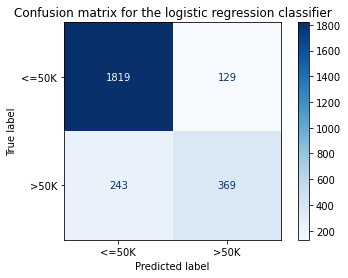

In [21]:
title = 'Confusion matrix for the logistic regression classifier'
disp = plot_confusion_matrix(classifier, 
                             X_test_proc, 
                             y_test,
                             display_labels=target_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                            )
disp.ax_.set_title(title)

In [22]:
print('Test accuracy: ', accuracy_score(y_test, classifier.predict(X_test_proc)))

Test accuracy:  0.8546875


## Running KernelSHAP in sequential mode

A background dataset is selected. 

In [23]:
start_example_idx = 0
stop_example_idx = 100
background_data = slice(start_example_idx, stop_example_idx)

Groups are specified by creating a list where each sublist contains the column indices that a given variable occupies in the preprocessed feature matrix.

In [24]:
def make_groups(num_feats_names: List[str], cat_feats_names: List[str], feat_enc_dim: List[int]) -> Tuple[List[str], List[List[int]]]:
    """
    Given a list with numerical feat. names, categorical feat. names
    and a list specifying the lengths of the encoding for each cat.
    varible, the function outputs a list of group names, and a list
    of the same len where each entry represents the column indices that
    the corresponding categorical feature 
    """
    
    group_names = num_feats_names + cat_feats_names
    groups = []
    cat_var_idx = 0
    
    for name in group_names: 
        if name in num_feats_names:
            groups.append(list(range(len(groups), len(groups) + 1)))
        else:
            start_idx = groups[-1][-1] + 1 if groups else 0
            groups.append(list(range(start_idx, start_idx + feat_enc_dim[cat_var_idx] )))
            cat_var_idx += 1
    
    return group_names, groups
            
def sparse2ndarray(mat, examples=None):
    """
    Converts a scipy.sparse.csr.csr_matrix to a numpy.ndarray.
    If specified, examples is slice object specifying which selects a
    number of rows from mat and converts only the respective slice.
    """
    
    if examples:
        return mat[examples, :].toarray()
    
    return mat.toarray()

X_train_proc_d = sparse2ndarray(X_train_proc, examples=background_data)
group_names, groups = make_groups(num_feats_names, cat_feats_names, feat_enc_dim)

Initialise and run the explainer sequentially.

In [ ]:
pred_fcn = classifier.predict_proba
seq_lr_explainer = KernelShap(pred_fcn, link='logit', feature_names=perm_feat_names)
seq_lr_explainer.fit(X_train_proc_d[background_data, :], group_names=group_names, groups=groups)

In [26]:
n_runs = 3

In [27]:
s_explanations, s_times = [], []

In [ ]:
for run in range(n_runs):
    t_start = timer()
    explanation = seq_lr_explainer.explain(sparse2ndarray(X_explain_proc))
    t_elapsed = timer() - t_start
    s_times.append(t_elapsed)
    s_explanations.append(explanation.shap_values)

## Running KernelSHAP in distributed mode

The only change needed to distribute the computation is to pass a dictionary containing the number of (physical) CPUs available to distribute the computation to the `KernelShap` constructor:

In [29]:
def distrib_opts_factory(n_cpus: int) -> Dict[str, int]:
    return {'n_cpus': n_cpus}

In [30]:
cpu_range = range(2, 5)
distrib_avg_times = dict(zip(cpu_range, [0.0]*len(cpu_range)))
distrib_min_times = dict(zip(cpu_range, [0.0]*len(cpu_range))) 
distrib_max_times = dict(zip(cpu_range, [0.0]*len(cpu_range))) 
d_explanations = defaultdict(list)

In [ ]:
for n_cpu in cpu_range:
    opts = distrib_opts_factory(n_cpu)
    distrib_lr_explainer = KernelShap(pred_fcn, link='logit', feature_names=perm_feat_names, distributed_opts=opts)
    distrib_lr_explainer.fit(X_train_proc_d[background_data, :], group_names=group_names, groups=groups)
    raw_times = []
    for _ in range(n_runs):
        t_start = timer()
        d_explanations[n_cpu].append(distrib_lr_explainer.explain(sparse2ndarray(X_explain_proc), silent=True).shap_values)
        t_elapsed = timer() - t_start
        raw_times.append(t_elapsed)
    distrib_avg_times[n_cpu] = np.round(np.mean(raw_times), 3)
    distrib_min_times[n_cpu] = np.round(np.min(raw_times), 3)
    distrib_max_times[n_cpu] = np.round(np.max(raw_times), 3)
    ray.shutdown()

## Results analysis

### Timing

In [41]:
print(f"Distributed average times for {n_runs} runs (n_cpus: avg_time):")
print(distrib_avg_times)
print("")
print(f"Sequential average time for {n_runs} runs:")
print(np.round(np.mean(s_times), 3), "s")

Distributed average times for 3 runs (n_cpus: avg_time):
{2: 57.197, 3: 41.728, 4: 36.751}

Sequential average time for 3 runs:
119.656 s


Running KernelSHAP in a distributed fashion improves the runtime as the results above show. However, the results above should not be interpreted as performance measurements since they were not run in a controlled environment. See our [blog post](https://www.seldon.io/how-seldons-alibi-and-ray-make-model-explainability-easy-and-scalable/) for a more thorough analysis.

### Explanations comparison

In [33]:
cls = 0  # class of prediction explained
run = 1  # which run to compare the result for

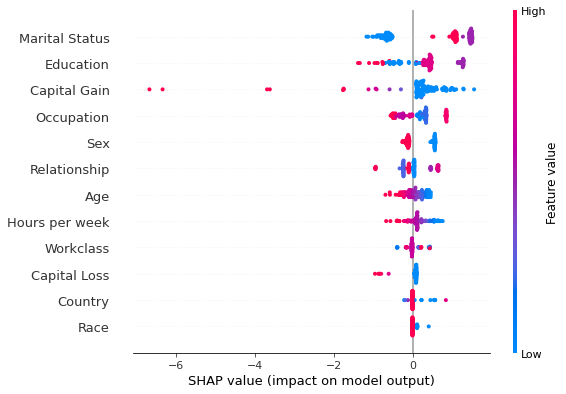

In [34]:
# sequential
shap.summary_plot(s_explanations[run][cls], perm_X_explain, perm_feat_names)

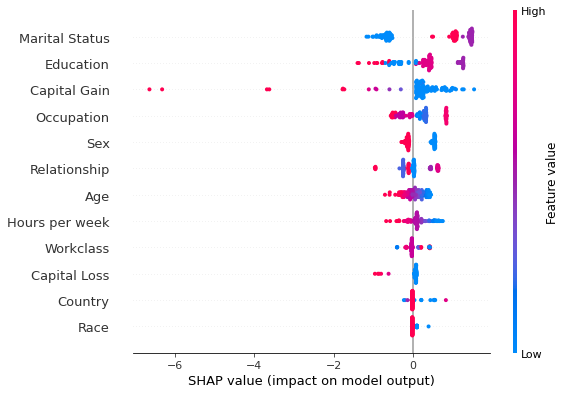

In [36]:
# distributed
n_cpu = 3
shap.summary_plot(d_explanations[n_cpu][run][cls], perm_X_explain, perm_feat_names)

Comparing the results above one sees that the running the algorithm across multiple cores gave identical results, indicating its correctness.

## Conclusion

This example showed that batches of explanations can be explained much faster by simply passing ``distributed_opts={'n_cpus': k}`` to the ``KernelShap`` constructor (here ``k`` is the number of physical cores available). The significant runtime reduction makes it possible to explain larger datasets faster and combine shap values estimated with KernelSHAP into global explanations or use larger background datasets.